# Walmart Sales Forecasting

### Objective:
#### The primary goal is to forecast the weekly sales of the store. Given the dataset's features encompassing size and time-related information, the aim is to examine how sales are influenced by time-based  and space-based factors.

##### The use case originates from Kaggle, and the downloaded data can be accessed through this link: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast. The source consists of four datasets, encompassing sales volume, features, train, and test data.


In [1]:
# importing packages 
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error
from math import sqrt


import warnings
warnings.filterwarnings("ignore")

max_date = pd.to_datetime("2013-02-01")

In [2]:
path = "C:/Users/RAJAVARUN/Desktop/Forecasting Analysis/archive/"

In [3]:
sales = pd.read_csv(path+"train.csv")
stores = pd.read_csv(path+"stores.csv")
features = pd.read_csv(path+"features.csv")
test = pd.read_csv(path+"test.csv")

In [4]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
print(sales["Store"].nunique(),sales["Dept"].nunique())

45 81


In [6]:
sales["Date"] = pd.to_datetime(sales["Date"])
print(sales["Date"].min(),sales["Date"].max())

2010-02-05 00:00:00 2012-10-26 00:00:00


In [7]:
print(sales["Date"].min(),sales["Date"].max())

2010-02-05 00:00:00 2012-10-26 00:00:00


In [8]:
sales.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [9]:
sales.shape

(421570, 5)

In [10]:
sales = sales[sales["Weekly_Sales"]>=0]

In [11]:
sales.describe()

,Store,Dept,Weekly_Sales
count,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773
std,12.787213,30.507197,22728.500149
min,1.000000,1.000000,0.000000
25%,11.000000,18.000000,2117.560000
50%,22.000000,37.000000,7659.090000
75%,33.000000,74.000000,20268.380000
max,45.000000,99.000000,693099.360000


In [12]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [13]:
sales = pd.concat([sales,test])
sales["Date"] = pd.to_datetime(sales["Date"])

In [14]:
# missing date imputation

max_date = pd.to_datetime("2013-02-01")
imputed_df = pd.DataFrame()
sales["ID"] = sales["Store"].astype(str)+"-"+sales["Dept"].astype(str)

for i in sales["ID"].unique():
    inner = sales[sales["ID"]==i]
    min_date = inner["Date"].min()
    date_series = pd.date_range(min_date,max_date,freq="W-FRI")
    date_df = pd.DataFrame({"Date":date_series})
    merge_df = pd.merge(date_df,inner,how="left",on="Date")
    merge_df.drop("ID",axis=1,inplace=True)
    imputed_df = pd.concat([imputed_df,merge_df])
    imputed_df.fillna(0,inplace=True)
    
sales = imputed_df.copy(deep=True)

In [15]:
sales.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday
0,2010-02-05,1.0,1.0,24924.50,False
1,2010-02-12,1.0,1.0,46039.49,True
2,2010-02-19,1.0,1.0,41595.55,False
3,2010-02-26,1.0,1.0,19403.54,False
4,2010-03-05,1.0,1.0,21827.90,False


In [16]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [17]:
print(stores["Store"].nunique(),stores["Type"].nunique())

45 3


In [18]:
df = pd.merge(sales,stores,on = 'Store', how='left')

In [19]:
df.describe()

,Store,Dept,Weekly_Sales,Size
count,507311.000000,507311.000000,507311.000000,461824.000000
mean,20.206335,40.286680,13280.427881,136719.178512
std,13.752094,31.745775,21551.975364,61004.518063
min,0.000000,0.000000,0.000000,34875.000000
25%,8.000000,12.000000,274.390000,93638.000000
50%,20.000000,33.000000,4851.920000,140167.000000
75%,32.000000,71.000000,16568.750000,202505.000000
max,45.000000,99.000000,693099.360000,219622.000000


In [20]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [21]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [22]:
features["Date"] = pd.to_datetime(features["Date"])

In [23]:
df = pd.merge(df,features,on=["Store","Date"],how="left")

In [24]:
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

<AxesSubplot:xlabel='week'>

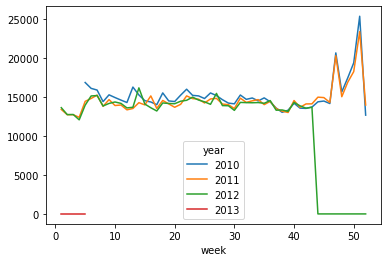

In [25]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

In [26]:
# extracting data for latest 1 year present in dataset
df = df[df["Date"]>=pd.to_datetime('2011-09-30')]
print(df["Date"].min(),df["Date"].max())

2011-09-30 00:00:00 2013-02-01 00:00:00


In [27]:
df.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,week,month,year
86,2011-09-30,1.0,1.0,18337.68,False,A,151315.0,79.69,3.355,NaN,NaN,NaN,NaN,NaN,216.710597,7.962,False,39,9,2011
87,2011-10-07,1.0,1.0,20797.58,False,A,151315.0,69.31,3.285,NaN,NaN,NaN,NaN,NaN,217.045368,7.866,False,40,10,2011
88,2011-10-14,1.0,1.0,23077.55,False,A,151315.0,71.74,3.274,NaN,NaN,NaN,NaN,NaN,217.355273,7.866,False,41,10,2011
89,2011-10-21,1.0,1.0,23351.80,False,A,151315.0,63.71,3.353,NaN,NaN,NaN,NaN,NaN,217.515976,7.866,False,42,10,2011
90,2011-10-28,1.0,1.0,31579.90,False,A,151315.0,66.57,3.372,NaN,NaN,NaN,NaN,NaN,217.676679,7.866,False,43,10,2011


In [28]:
df["check_holiday"] = df['IsHoliday_x'].equals(df['IsHoliday_y'])

In [29]:
df["check_holiday"].nunique()

1

In [30]:
df.drop(["IsHoliday_y","check_holiday"],axis=1,inplace=True)

In [31]:
df.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)

In [32]:
df.columns

Index(['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'week', 'month',
       'year'],
      dtype='object')

In [33]:
df.isnull().sum()

Date                0
Store               0
Dept                0
Weekly_Sales        0
IsHoliday           0
Type            24446
Size            24446
Temperature     24446
Fuel_Price      24446
MarkDown1       42923
MarkDown2       93315
MarkDown3       59587
MarkDown4       63379
MarkDown5       42126
CPI             24446
Unemployment    24446
week                0
month               0
year                0
dtype: int64

In [34]:
df.fillna(0,inplace=True)

<AxesSubplot:xlabel='week'>

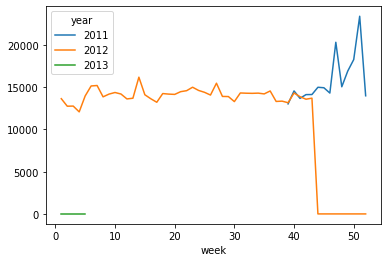

In [35]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

<AxesSubplot:xlabel='Fuel_Price'>

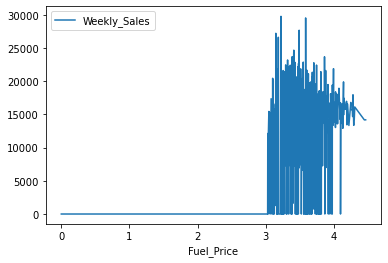

In [36]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<AxesSubplot:xlabel='Temperature'>

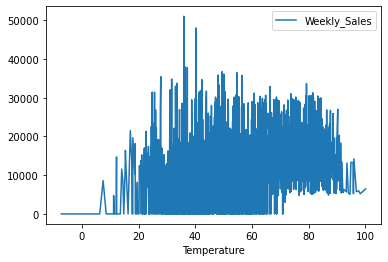

In [37]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<AxesSubplot:xlabel='CPI'>

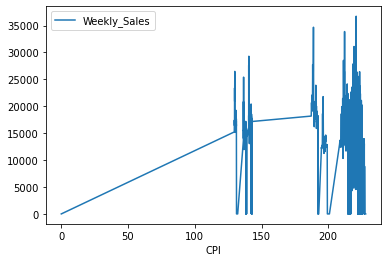

In [38]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<AxesSubplot:xlabel='Unemployment'>

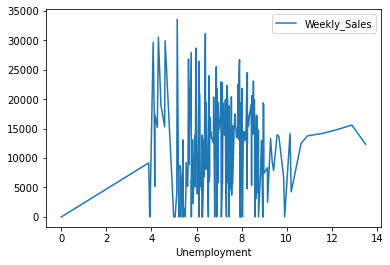

In [39]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

In [40]:
df.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,year
86,2011-09-30,1.0,1.0,18337.68,False,A,151315.0,79.69,3.355,0.0,0.0,0.0,0.0,0.0,216.710597,7.962,39,9,2011
87,2011-10-07,1.0,1.0,20797.58,False,A,151315.0,69.31,3.285,0.0,0.0,0.0,0.0,0.0,217.045368,7.866,40,10,2011
88,2011-10-14,1.0,1.0,23077.55,False,A,151315.0,71.74,3.274,0.0,0.0,0.0,0.0,0.0,217.355273,7.866,41,10,2011
89,2011-10-21,1.0,1.0,23351.80,False,A,151315.0,63.71,3.353,0.0,0.0,0.0,0.0,0.0,217.515976,7.866,42,10,2011
90,2011-10-28,1.0,1.0,31579.90,False,A,151315.0,66.57,3.372,0.0,0.0,0.0,0.0,0.0,217.676679,7.866,43,10,2011


In [41]:
df.to_csv(path+"combined_data.csv")

In [42]:
#encoding the labelled data
type_data = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df['Type'] = df['Type'].replace(type_data)

df['IsHoliday'] = df['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [43]:
df.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,year
86,2011-09-30,1.0,1.0,18337.68,0,1,151315.0,79.69,3.355,0.0,0.0,0.0,0.0,0.0,216.710597,7.962,39,9,2011
87,2011-10-07,1.0,1.0,20797.58,0,1,151315.0,69.31,3.285,0.0,0.0,0.0,0.0,0.0,217.045368,7.866,40,10,2011
88,2011-10-14,1.0,1.0,23077.55,0,1,151315.0,71.74,3.274,0.0,0.0,0.0,0.0,0.0,217.355273,7.866,41,10,2011
89,2011-10-21,1.0,1.0,23351.80,0,1,151315.0,63.71,3.353,0.0,0.0,0.0,0.0,0.0,217.515976,7.866,42,10,2011
90,2011-10-28,1.0,1.0,31579.90,0,1,151315.0,66.57,3.372,0.0,0.0,0.0,0.0,0.0,217.676679,7.866,43,10,2011


In [44]:
# creating cyclic features as time series feature
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [45]:
df = encode(df, 'month', 12)
df = encode(df, 'week', 52)

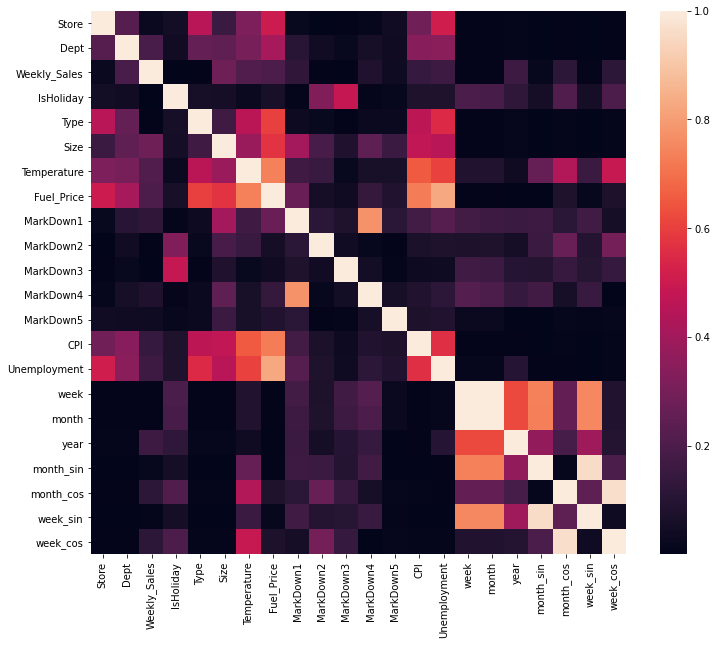

In [46]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show()

In [47]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df.drop(drop_col, axis=1, inplace=True) # dropping columns

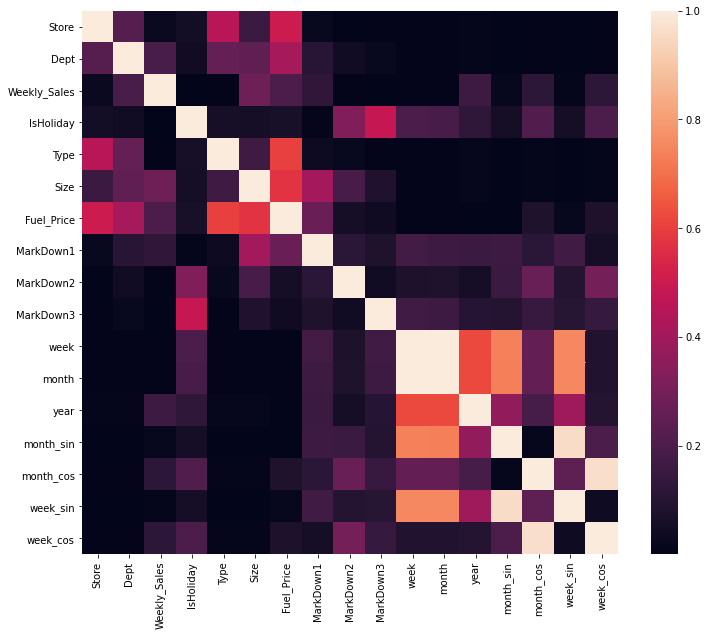

In [48]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show()

#### Exploration and Finding
##### 1) There are 45 stores and 81 department in data. Departments are not same in all stores. 
##### 2) CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales.
##### 3) Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.
##### 4) Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe.
##### 5) There is a bit of seasonality and trend when looked into complete data but after extracting it for one year of data 

In [49]:
df_final = df.sort_values(by='Date', ascending=True)

In [50]:
df_final["week"].unique()

array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38], dtype=int64)

In [51]:
df_final.to_csv(path+"final_data.csv",index=False)

In [52]:
cols = [c for c in df_final.columns.to_list() if c not in ['Weekly_Sales',"Date","week","month"]]

In [53]:
x_train = df_final[df_final["Date"]<=pd.to_datetime('2012-08-31')][cols]
x_valid = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))][cols]
x_test = df_final[df_final["Date"]>pd.to_datetime('2012-10-26')][cols]
y_train = df_final[df_final["Date"]<=pd.to_datetime('2012-08-31')]["Weekly_Sales"]
y_valid = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]["Weekly_Sales"]

In [54]:
# defination of model building functions to improve code reuseability

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
def imp_features(df_final):
    model = DecisionTreeRegressor()
    model.fit(x_train,y_train)
    impt_feat = model.feature_importances_
    columns = df_final.columns
    feat_df = pd.DataFrame({'Features':columns,'val':impt_feat})
    feat_df.sort_values(by=["val"],ascending=False,inplace=True)
    return feat_df

def valid(train,test,y_train,y_test):
    model = RandomForestRegressor()
    params={'n_estimators':[50,100,150,200,250,300],
                  'max_depth': [2,3,4]}
    rs = RandomizedSearchCV(model, params, n_jobs=-1)
    rs_f=rs.fit(train,y_train)
    return rs_f.best_params_
    
def rf_model(train,y,test,feat,params):
    model = RandomForestRegressor(random_state=42,n_estimators=params["n_estimators"]
                                  ,max_depth=params["max_depth"])
    train = train[feat]
    test = test[feat]
    model.fit(train,y)
    pred = model.predict(test)
    return pred

def esm(train,test):
    try:
        model_holt_winters = ExponentialSmoothing(train["Weekly_Sales"], seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
        y_pred = model_holt_winters.forecast(len(test))# Predict the test data
    except:
        try:
            model_holt_winters = ExponentialSmoothing(train["Weekly_Sales"]).fit()
            y_pred = model_holt_winters.forecast(len(test))# Predict the test data
        except Exception as e:
            y_pred = 0
    
    return y_pred
    

#### Implementation of Machine Learning Algorithm for 1 year data

In [55]:
params = valid(x_train,x_valid,y_train,y_valid)

In [56]:
params

{'n_estimators': 250, 'max_depth': 4}

In [57]:
feat = imp_features(x_train)
feat.reset_index(inplace=True)

In [58]:
feat

,index,Features,val
0,1,Dept,0.636890
1,4,Size,0.184737
2,0,Store,0.070721
3,8,MarkDown3,0.043058
4,3,Type,0.017919
5,13,week_cos,0.013455
6,11,month_cos,0.007891
7,6,MarkDown1,0.006966
8,5,Fuel_Price,0.006884
9,7,MarkDown2,0.004755


In [59]:
# considering top 10 features only.
pred_valid = rf_model(x_train,y_train,x_valid,list(feat["Features"]),params)

In [60]:
mape_ml_1yr = mean_absolute_percentage_error(y_valid,pred_valid)

In [61]:
mae_ml_1yr = mean_absolute_error(y_valid,pred_valid)

In [62]:
rmse_ml_1yr = sqrt(mean_squared_error(y_valid,pred_valid))

In [63]:
x_ = df_final[df_final["Date"]<=pd.to_datetime('2012-10-26')][cols]
x_test = df_final[(df_final["Date"]>pd.to_datetime('2012-10-26') ) 
                   & (df_final["Date"]<=max_date)][cols]

y_ = df_final[df_final["Date"]<=pd.to_datetime('2012-10-26')]["Weekly_Sales"]


In [64]:
pred_valid = rf_model(x_,y_,x_test,list(feat["Features"][:10]),params)

In [66]:
final_graph_train = x_.copy(deep=True)
final_graph_train["Actual"] = y_

In [67]:
x_test["pred"] = pred_valid
ml_pred = x_test.copy(deep=True)

#### Implementation of Time Series Algorithm for 1 year data

In [68]:
# time series implementation

train_data_diff = df_final[df_final["Date"]<=pd.to_datetime('2012-08-31')]
#train_data_diff.set_index(['Date'],inplace=True)
test_data_diff = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]
train_data_diff.set_index(['Date'],inplace=True)

In [69]:
train_t = df_final[df_final["Date"]<=pd.to_datetime('2012-08-31')]
#train_data_diff.set_index(['Date'],inplace=True)
test_t = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]

train_t = train_t[["Date","Store","Dept","Weekly_Sales"]]
test_t = test_t[["Date","Store","Dept","Weekly_Sales"]]


In [70]:
train_t["ID"] = train_t["Store"].astype(str)+"-"+train_t["Dept"].astype(str)
test_t["ID"] = test_t["Store"].astype(str)+"-"+test_t["Dept"].astype(str)

In [71]:
train_t.set_index(['Date'],inplace=True)
test_t.set_index(['Date'],inplace=True)

In [72]:
train_t.head()

,Store,Dept,Weekly_Sales,ID
Date,,,,
2011-09-30,1.0,1.0,18337.68,1.0-1.0
2011-09-30,15.0,94.0,95.52,15.0-94.0
2011-09-30,15.0,93.0,294.58,15.0-93.0
2011-09-30,15.0,92.0,17077.45,15.0-92.0
2011-09-30,15.0,91.0,3419.08,15.0-91.0


In [73]:
train_t["ID"].nunique()

3235

In [74]:
time_series_valid = pd.DataFrame()
count = 0
for i in train_t["ID"].unique():
    train_series = train_t[train_t["ID"]==i]
    test_series = test_t[test_t["ID"]==i]
    try:
        test_series["pred"] = esm(train_series,test_series)
    except Exception as e:
        count = count+1
    final = pd.concat([train_series,test_series])
    time_series_valid = pd.concat([time_series_valid,final])

In [75]:
time_series_valid.reset_index(inplace=True)
time_series_valid["Date"] = pd.to_datetime(time_series_valid["Date"])

In [76]:
metric_df = time_series_valid[(time_series_valid["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (time_series_valid["Date"]<=pd.to_datetime('2012-10-26'))]

In [77]:
mae_ts_1yr = mean_absolute_error(metric_df["Weekly_Sales"],metric_df["pred"].fillna(0))

In [78]:
mape_ts_1yr = mean_absolute_percentage_error(metric_df["Weekly_Sales"],metric_df["pred"].fillna(0))

In [79]:
rmse_ts_1yr = sqrt(mean_squared_error(metric_df["Weekly_Sales"],metric_df["pred"].fillna(0)))

In [80]:
train_t = df_final[df_final["Date"]<=pd.to_datetime('2012-10-26')]
#train_data_diff.set_index(['Date'],inplace=True)
test_t = df_final[(df_final["Date"]>pd.to_datetime('2012-10-26') ) 
                   & (df_final["Date"]<=max_date)]

train_t = train_t[["Date","Store","Dept","Weekly_Sales"]]
test_t = test_t[["Date","Store","Dept","Weekly_Sales"]]

train_t.set_index(['Date'],inplace=True)
test_t.set_index(['Date'],inplace=True)

In [81]:
train_t["ID"] = train_t["Store"].astype(str)+"-"+train_t["Dept"].astype(str)
test_t["ID"] = test_t["Store"].astype(str)+"-"+test_t["Dept"].astype(str)

In [82]:
test_t.head()

,Store,Dept,Weekly_Sales,ID
Date,,,,
2012-11-02,32.0,26.0,0.0,32.0-26.0
2012-11-02,14.0,29.0,0.0,14.0-29.0
2012-11-02,12.0,81.0,0.0,12.0-81.0
2012-11-02,25.0,27.0,0.0,25.0-27.0
2012-11-02,9.0,27.0,0.0,9.0-27.0


In [83]:
time_series_pred = pd.DataFrame()
count = 0
pred_series_1yr = pd.DataFrame()
for i in train_t["ID"].unique():
    train_series = train_t[train_t["ID"]==i]
    test_series = test_t[test_t["ID"]==i]
    try:
        test_series["pred"] = esm(train_series,test_series)
    except Exception as e:
        count = count+1
    final = pd.concat([train_series,test_series])
    pred_series_1yr = pd.concat([pred_series_1yr,test_series])
    time_series_pred = pd.concat([time_series_pred,final])

In [84]:
time_series_pred.reset_index(inplace=True)

In [85]:
pred_series_1yr.reset_index(inplace=True)

In [86]:
time_series_pred = time_series_pred[["Date","Weekly_Sales","pred"]]

In [87]:
time_series_pred_gp = time_series_pred.groupby(["Date"]).agg({"Weekly_Sales":sum,"pred":sum})

In [88]:
time_series_pred_gp.reset_index(inplace=True)

In [89]:
time_series_pred.index = time_series_pred["Date"]

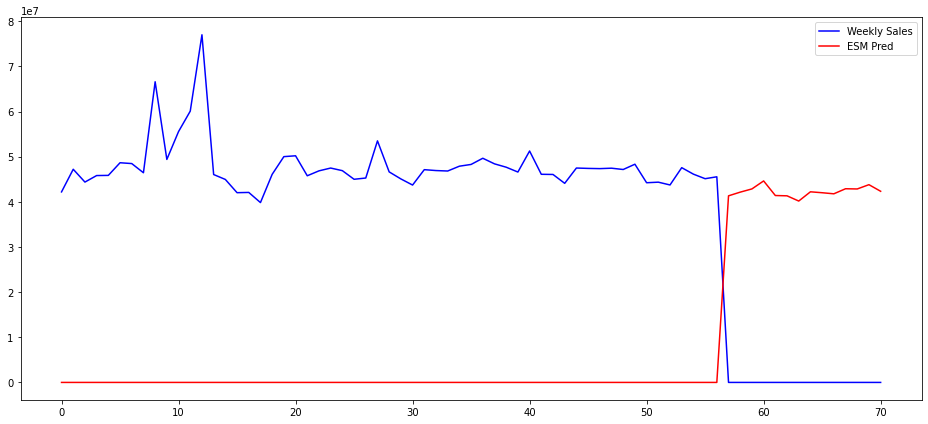

In [90]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(time_series_pred_gp['Weekly_Sales'], color='blue',label='Weekly Sales')
ax.plot(time_series_pred_gp["pred"], color='red', label='ESM Pred')
ax.legend()
fig.tight_layout()


#### Implementation of Machine Learning Algorithm for 6 months data

In [92]:
#for 6 month data

In [93]:
from dateutil.relativedelta import relativedelta
back_date = pd.to_datetime('2012-08-31') + relativedelta(months=-6)
back_date

Timestamp('2012-02-29 00:00:00')

In [94]:
back_date = pd.to_datetime('2012-08-31') + relativedelta(months=-6)
x_train_6m = df_final[(df_final["Date"] > pd.to_datetime("2012-02-29")) 
                      & (df_final["Date"]<=pd.to_datetime('2012-08-31'))][cols]
x_valid_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))][cols]
x_test_6m = df_final[df_final["Date"]>pd.to_datetime('2012-10-26')][cols]
y_train_6m = df_final[(df_final["Date"] > pd.to_datetime("2012-02-29")) 
                      & (df_final["Date"]<=pd.to_datetime('2012-08-31'))]["Weekly_Sales"]
y_valid_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]["Weekly_Sales"]

In [95]:
params = valid(x_train_6m,x_valid_6m,y_train_6m,y_valid_6m)

In [96]:
params

{'n_estimators': 300, 'max_depth': 4}

In [97]:
feat = imp_features(x_train)
feat.reset_index(inplace=True)

In [98]:
pred_valid = rf_model(x_train_6m,y_train_6m,x_valid_6m,list(feat["Features"][:10]),params)

In [99]:
mape_ml_6m = mean_absolute_percentage_error(y_valid_6m,pred_valid)

In [100]:
mae_ml_6m = mean_absolute_error(y_valid_6m,pred_valid)

In [101]:
rmse_ml_6m = sqrt(mean_squared_error(y_valid,pred_valid))

In [102]:
x_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-02-29') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))][cols]
x_test_6m = df_final[df_final["Date"]>pd.to_datetime('2012-10-26')][cols]

y_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-02-29') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]["Weekly_Sales"]




In [103]:
pred_valid = rf_model(x_6m,y_6m,x_test_6m,list(feat["Features"][:10]),params)

# done with 6m weekly forecast

In [104]:
ml_pred_6m = x_test.copy(deep=True)
ml_pred_6m["pred"] = pred_valid


#### Implementation of Time Series Algorithm for 6 months data

In [105]:
train_t_6m = df_final[(df_final["Date"] > pd.to_datetime("2012-02-29")) 
                      & (df_final["Date"]<=pd.to_datetime('2012-08-31'))]
test_t_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]

train_t_6m = train_t_6m[["Date","Store","Dept","Weekly_Sales"]]
test_t_6m = test_t_6m[["Date","Store","Dept","Weekly_Sales"]]


In [106]:
train_t_6m.set_index(['Date'],inplace=True)
test_t_6m.set_index(['Date'],inplace=True)

In [107]:
train_t_6m["ID"] = train_t_6m["Store"].astype(str)+"-"+train_t_6m["Dept"].astype(str)
test_t_6m["ID"] = test_t_6m["Store"].astype(str)+"-"+test_t_6m["Dept"].astype(str)

In [108]:
time_series_valid_6m = pd.DataFrame()
count = 0
for i in train_t_6m["ID"].unique():
    train_series = train_t_6m[train_t_6m["ID"]==i]
    test_series = test_t_6m[test_t_6m["ID"]==i]
    try:
        test_series["pred"] = esm(train_series,test_series)
    except Exception as e:
        count = count+1
    final = pd.concat([train_series,test_series])
    time_series_valid_6m = pd.concat([time_series_valid_6m,final])

In [109]:
time_series_valid_6m.reset_index(inplace=True)
time_series_valid_6m["Date"] = pd.to_datetime(time_series_valid_6m["Date"])

In [110]:
metric_df_6m = time_series_valid_6m[(time_series_valid_6m["Date"]>pd.to_datetime('2012-08-31') ) 
                   & (time_series_valid_6m["Date"]<=pd.to_datetime('2012-10-26'))]

In [111]:
mae_ts_6m = mean_absolute_error(metric_df_6m["Weekly_Sales"],metric_df_6m["pred"].fillna(0))

In [112]:
mape_ts_6m = mean_absolute_percentage_error(metric_df_6m["Weekly_Sales"],metric_df_6m["pred"].fillna(0))

In [113]:
rmse_ts_6m = sqrt(mean_squared_error(metric_df_6m["Weekly_Sales"],metric_df_6m["pred"].fillna(0)))

In [114]:
train_t_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-08-31')) 
                       & (df_final["Date"]<=pd.to_datetime('2012-10-26'))]
#train_data_diff.set_index(['Date'],inplace=True)
test_t_6m = df_final[(df_final["Date"]>pd.to_datetime('2012-10-26') ) 
                   & (df_final["Date"]<=max_date)]

train_t_6m = train_t_6m[["Date","Store","Dept","Weekly_Sales"]]
test_t_6m = test_t_6m[["Date","Store","Dept","Weekly_Sales"]]

train_t_6m.set_index(['Date'],inplace=True)
test_t_6m.set_index(['Date'],inplace=True)

In [115]:
train_t_6m["ID"] = train_t_6m["Store"].astype(str)+"-"+train_t_6m["Dept"].astype(str)
test_t_6m["ID"] = test_t_6m["Store"].astype(str)+"-"+test_t_6m["Dept"].astype(str)

In [116]:
time_series_pred_6m = pd.DataFrame()
count = 0
pred_series_6m = pd.DataFrame()
for i in train_t_6m["ID"].unique():
    train_series = train_t_6m[train_t_6m["ID"]==i]
    test_series = test_t_6m[test_t_6m["ID"]==i]
    try:
        test_series["pred"] = esm(train_series,test_series)
    except Exception as e:
        print(e)
        count = count+1
    pred_series_6m = pd.concat([pred_series_6m,test_series])
    final = pd.concat([train_series,test_series])
    time_series_pred_6m = pd.concat([time_series_pred_6m,final])

In [117]:
time_series_pred_6m.reset_index(inplace=True)
time_series_pred_6m = time_series_pred_6m[["Date","Weekly_Sales","pred"]]

In [118]:
pred_series_6m.head()

,Store,Dept,Weekly_Sales,ID,pred
Date,,,,,
2012-11-02,25.0,52.0,0.0,25.0-52.0,1480.21319
2012-11-09,25.0,52.0,0.0,25.0-52.0,1480.21319
2012-11-16,25.0,52.0,0.0,25.0-52.0,1480.21319
2012-11-23,25.0,52.0,0.0,25.0-52.0,1480.21319
2012-11-30,25.0,52.0,0.0,25.0-52.0,1480.21319


In [119]:
time_series_pred_gp = time_series_pred_6m.groupby(["Date"]).agg({"Weekly_Sales":sum,"pred":sum})
time_series_pred_gp.reset_index(inplace=True)

In [120]:
time_series_pred_gp.index = time_series_pred_gp["Date"]

#### Summary of Model Output for 1year and 6month data


In [126]:
int(mape_ml_1yr)

37446568302365400

In [131]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Algorithm","MAPE"]
x.add_rows(
    [
        ["ML - 1yr data",mape_ml_1yr],
        ["Time Series - 1yr data",mape_ts_1yr],
        ["ML - 6months data",mape_ml_6m],
        ["Time Series - 6months data",mape_ts_6m]
    ]
)
print(x)

+----------------------------+-----------------------+
|         Algorithm          |          MAPE         |
+----------------------------+-----------------------+
|       ML - 1yr data        |  3.74465683023654e+16 |
|   Time Series - 1yr data   |   0.5690869318314249  |
|     ML - 6months data      | 2.213051515125181e+16 |
| Time Series - 6months data |  0.29401809322463346  |
+----------------------------+-----------------------+


##### Exponential smoothing outperforms the ML algorithm significantly. This could be attributed to the ML algorithm's utilization of fewer data features, along with the use of either 1-year or 6-months duration data.

In [162]:
final_graph_train = df_final[df_final["Date"]<=pd.to_datetime('2012-10-26')]
final_graph_train = final_graph_train[["Date","Store","Dept","Weekly_Sales"]]
final_graph_train = final_graph_train.groupby(["Date"]).agg({"Weekly_Sales":sum})
#final_graph_train.reset_index(inplace=True)

x_test_ml_1yr = df_final[(df_final["Date"]>pd.to_datetime('2012-10-26') ) 
                   & (df_final["Date"]<=max_date)]
x_test_ml_1yr["ML Prediction one year"] = ml_pred["pred"]
x_test_ml_1yr = x_test_ml_1yr[["Date","Store","Dept","ML Prediction one year"]]
x_test_ml_1yr = x_test_ml_1yr.groupby(["Date"]).agg({"ML Prediction one year":sum})
#x_test_ml_1yr.reset_index(inplace=True)

x_test_ml_6mon = df_final[(df_final["Date"]>pd.to_datetime('2012-10-26') ) 
                   & (df_final["Date"]<=max_date)]
x_test_ml_6mon["ML Prediction 6months"] = ml_pred_6m["pred"]
x_test_ml_6mon = x_test_ml_6mon[["Date","Store","Dept","ML Prediction 6months"]]
x_test_ml_6mon = x_test_ml_6mon.groupby(["Date"]).agg({"ML Prediction 6months":sum})
#x_test_ml_6mon.reset_index(inplace=True)

pred_series_1yr.rename(columns={"pred":"Time Series 1year"},inplace=True)
pred_series_1yr = pred_series_1yr[["Date","Store","Dept","Time Series 1year"]]
pred_series_1yr = pred_series_1yr.groupby(["Date"]).agg({"Time Series 1year":sum})
#pred_series_1yr.reset_index(inplace=True)

pred_series_6m.reset_index(inplace=True)
pred_series_6m.rename(columns={"pred":"Time Series 6mon"},inplace=True)
pred_series_6m = pred_series_6m[["Date","Store","Dept","Time Series 6mon"]]
pred_series_6m = pred_series_6m.groupby(["Date"]).agg({"Time Series 6mon":sum})
#pred_series_6m.reset_index(inplace=True)


In [164]:
pred_series_1yr.index = pred_series_1yr["Date"]
pred_series_6m.index = pred_series_6m["Date"]

,Date,Time Series 6mon
Date,,
2012-11-02,2012-11-02,4.586872e+07
2012-11-09,2012-11-09,4.586630e+07
2012-11-16,2012-11-16,4.585877e+07
2012-11-23,2012-11-23,4.585481e+07
2012-11-30,2012-11-30,4.585516e+07


### Plot for comparison of forecacst

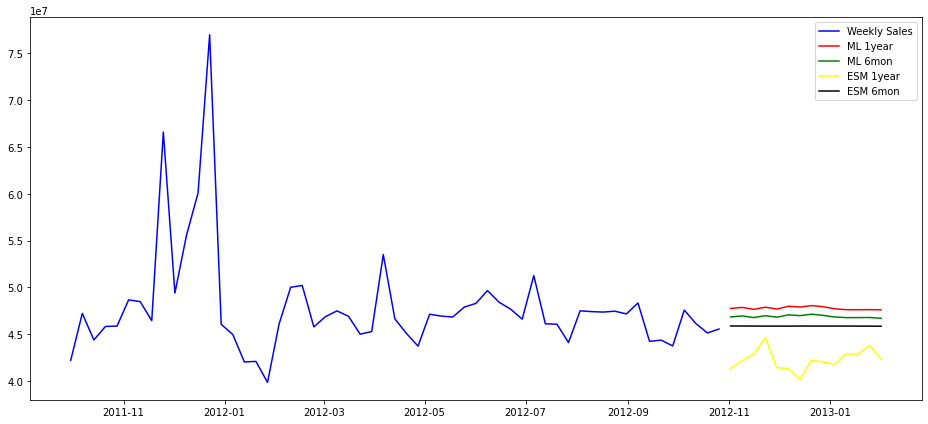

In [166]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(final_graph_train['Weekly_Sales'], color='blue',label='Weekly Sales')
ax.plot(x_test_ml_1yr["ML Prediction one year"], color='red', label='ML 1year')
ax.plot(x_test_ml_6mon["ML Prediction 6months"], color='green', label='ML 6mon')
ax.plot(pred_series_1yr["Time Series 1year"], color='yellow', label='ESM 1year')
ax.plot(pred_series_6m["Time Series 6mon"], color='black', label='ESM 6mon')
ax.legend()
fig.tight_layout()


#### The forecast observations are as follows:
#### 1) The machine learning (ML) model, when trained on both 1-year and 6-months data along with ESM 6-months data, shows an almost flat line in its forecasts. It struggles to capture the underlying trend or seasonality.
#### 2)On the other hand, the ESM model, trained solely on 1-year data, produces lower forecasts compared to other models. However, it has managed to capture some aspects of seasonality and trend.
#### 3)The ESM model trained on 6-months data demonstrates the lowest MAPE value, but it fails to capture the seasonality. In contrast, the ESM model trained on 1-year data performs the second best and successfully captures the seasonality and trend of the data.
#### 4)Incorporating more features, such as decomposing the data to capture seasonality and trend, could lead to an improvement in the output of the ML model.

#### Overall, using the ESM model with 1-year data is recommended, as it yields better forecast results compared to other models in the process.